Custom objective function
========================

Names of free parameters:  ['A', 'mu', 'sig', 'off']
Optimization terminated successfully.
         Current function value: 0.737605
         Iterations: 205
         Function evaluations: 358
Fit result:  [0.64467365 8.75706725 6.815535   1.00264823]
------------------- Parameter summary --------------------
      A =     0.644674, free: T, restricted: F, related: F
     mu =      8.75707, free: T, restricted: F, related: F
    sig =      6.81553, free: T, restricted: F, related: F
    off =      1.00265, free: T, restricted: F, related: F
    lin =            0, free: F, restricted: F, related: F
----------------------------------------------------------


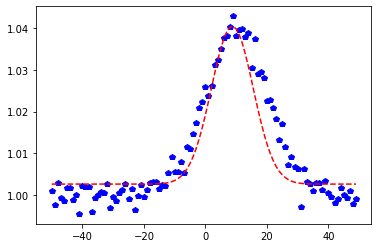

In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy import funcFit2 as fuf2
import scipy.optimize as sco

np.random.seed(1234)

# Creating a Gaussian with some noise
# Choose some parameters...
gPar = {"A":1.0, "sig":10.0, "mu":10.0, "off":1.0, "lin":0.0}
# Calculate profile
x = np.arange(100) - 50.0
y = gPar["off"] + gPar["A"] / np.sqrt(2*np.pi*gPar["sig"]**2) \
    * np.exp(-(x-gPar["mu"])**2/(2*gPar["sig"]**2))
# Add some noise...
y += np.random.normal(0.0, 0.002, x.size)
# ...and save the error bars
yerr = np.ones_like(x)*0.002

# Create a model object
gf = fuf2.GaussFit()
# Set guess values for the parameters
gf.assignValues({"A":2, "sig":3.77, "off":0.96, "mu":9.5})
# 'Thaw' those (the order is irrelevant)
gf.thaw(["mu", "sig", "off", "A"])


def myobjf(m, pars, x, y, **kwargs):
    """
    Calculate the absolute distance between model and data points and area of the Gaussian
    
    Parameters
    ----------
    m : MBO object
        On setting the objective function later via gf.objf = myobjf, this
        gives access to the parameter values, evaluate method of the model
        and so on.
    pars : list of floats
        Parameter values for which the objective function is to be evaluated.
        A correctly ordered list of free parameter values can be obtained
        by using the method freeParamVals(). The order by names can be inspected
        using the freeParamNames() method.
    x, y : arrays
        Here, this is the data. Note that these variables are specified via the
        'args' parameter later in the call to the optimization algorithm (fmin).
    silent : boolean
        Can be used to suppress output (also specified via 'args' parameter).
    """
    model = m.evaluate(x)
    r = np.sum(np.abs(model - y))
    # Weird dependence on A
    r += 0.6*np.abs(m["A"])
    # Some informative output
    fpv = tuple(zip((m.freeParamNames(), m.freeParamVals())))
    return r

# Show list of free parameters
print("Names of free parameters: ", gf.freeParamNames())

# Assign objective function. As a result of this assignment,
# the parameter values of the model will be set to those handed
# to the objective function prior to call
gf.addSPLikeObjf(myobjf, "myobjf")

fr = sco.fmin(gf.myobjf, gf.freeParamVals(), args=(x,y))
print("Fit result: ", fr)
# Set the parameter values to best-fit
gf.setFreeParamVals(fr)

gf.parameterSummary()
# Let us see what we have done...
plt.plot(x, y, 'bp')
plt.plot(x, gf.evaluate(x), 'r--')
plt.show()